In [1]:
import pandas as pd
import numpy as np

from utils import SentenceGetter
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report

from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D, Flatten
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, MaxPooling1D
from keras_contrib.layers import CRF
from keras.initializers import RandomUniform

import matplotlib.pyplot as plt




Using TensorFlow backend.
C:\Users\linar\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\linar\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\linar\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\linar\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

# Implement BiLSTM-CNN on data
At this part we are going to implement Named Entity Recognition with Bidirectional LSTM-CNNs based on the work <a href="https://arxiv.org/pdf/1511.08308.pdf">Chiu, J. P., & Nichols, E. (2016).</a> and then we expand this model to the BiLSTM-CNN-CRF model.  The overall network for BiLSTM-CNN model is presented on the figure below, however, we simplified it.

<table><tr>
<td> <img src="images/LSTM-CNN-1.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="images/LSTM-CNN-2.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="images/LSTM-CNN-3.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

We are going to:
1. Apply char embeddings by creating a dictionary of all characters and then mapping the ids to each character
2. Apply word embeddings by the same algorithm. Chiu and Nicols used GloVe word embeddings trained on 6 billions tokens from Wikipedia and Gigaword 5 (<a  href="https://nlp.stanford.edu/projects/glove/">Pennington et al., 2014. GloVe: Global Vectors for Word Representation.</a>), however, it does not contain all word representations for our dataset, therefore, it was decided not to use it. 
4. Apply CNN on char embeddings. We will try 2 different layers: 1) simple LSTM layer; 2) convolutional and max pooling layers (as it is described on fig.2).
5. Feed the output of CNN and word embeddings to the BiLSTM.
6. *For BiLSTM-CNN-CRF model, apply a CRF layer on top of created model.

## 0. Prepare data

In [2]:
#download data
data = pd.read_csv("ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")
data.tail(10)

,Sentence #,Word,POS,Tag
1048565,Sentence: 47958,impact,NN,O
1048566,Sentence: 47958,.,.,O
1048567,Sentence: 47959,Indian,JJ,B-gpe
1048568,Sentence: 47959,forces,NNS,O
1048569,Sentence: 47959,said,VBD,O
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O
1048574,Sentence: 47959,attack,NN,O


In [3]:
#create a getter which will transform sentences
getter = SentenceGetter(data)

In [4]:
sentences = getter.sentences
sentences[3]

[['They', 'O'],
 ['left', 'O'],
 ['after', 'O'],
 ['a', 'O'],
 ['tense', 'O'],
 ['hour-long', 'O'],
 ['standoff', 'O'],
 ['with', 'O'],
 ['riot', 'O'],
 ['police', 'O'],
 ['.', 'O']]

In [5]:
words = list(set(data["Word"].values))

### Create Mappings for Words, Characters and Tags
 We now have a list of sentences which are words along with their labels. Now, we want to map these individual words, labels and characters in each word, to unique numerical ID's so that each unique word, character and tag in the vocabulary is represented by a particular integer ID. To do this, we first create a functions that do these mapping for us

### Why mapping is important?
These indices for words, labels and characters help us employ matrix (tensor) operations inside the neural network architecture, which are considerably faster.

## 1. Char embeddings

In [6]:
chars = set([w_i for w in words for w_i in w])
print(chars)
print(len(chars))

{'g', 'V', '/', 'o', 'Z', '7', 'e', 'h', 's', 'T', 'v', '\xa0', ',', '`', 'J', 'x', '2', 'b', 'ü', '-', '9', 'é', 'G', '5', '.', '\x94', 'u', 'D', '+', '%', 'F', '"', 'r', 'W', 'l', '\x92', ']', '3', ':', '\x85', 'm', 'n', '\x91', 'H', 'L', 'z', 'k', 'E', '~', '0', 'Q', 'R', '\x93', 'y', 'q', 'd', '@', '6', '1', 'a', "'", 'ö', 'w', '\x96', 'ë', ';', '!', 'Y', 'N', '8', 'I', '$', 'P', 'B', '[', 'p', 'X', '4', 'M', '(', 'c', '\x97', 'j', 'S', '?', '&', 'O', 'A', 'U', '#', ')', 'i', 'f', 't', 'C', '_', '°', 'K'}
98


In [7]:
# Crate a mapping for characters
char2idx = {c: i + 1 for i, c in enumerate(chars)}
char2idx["PAD"] = 0 #use zero as a padding value
char2idx

{'g': 1,
 'V': 2,
 '/': 3,
 'o': 4,
 'Z': 5,
 '7': 6,
 'e': 7,
 'h': 8,
 's': 9,
 'T': 10,
 'v': 11,
 '\xa0': 12,
 ',': 13,
 '`': 14,
 'J': 15,
 'x': 16,
 '2': 17,
 'b': 18,
 'ü': 19,
 '-': 20,
 '9': 21,
 'é': 22,
 'G': 23,
 '5': 24,
 '.': 25,
 '\x94': 26,
 'u': 27,
 'D': 28,
 '+': 29,
 '%': 30,
 'F': 31,
 '"': 32,
 'r': 33,
 'W': 34,
 'l': 35,
 '\x92': 36,
 ']': 37,
 '3': 38,
 ':': 39,
 '\x85': 40,
 'm': 41,
 'n': 42,
 '\x91': 43,
 'H': 44,
 'L': 45,
 'z': 46,
 'k': 47,
 'E': 48,
 '~': 49,
 '0': 50,
 'Q': 51,
 'R': 52,
 '\x93': 53,
 'y': 54,
 'q': 55,
 'd': 56,
 '@': 57,
 '6': 58,
 '1': 59,
 'a': 60,
 "'": 61,
 'ö': 62,
 'w': 63,
 '\x96': 64,
 'ë': 65,
 ';': 66,
 '!': 67,
 'Y': 68,
 'N': 69,
 '8': 70,
 'I': 71,
 '$': 72,
 'P': 73,
 'B': 74,
 '[': 75,
 'p': 76,
 'X': 77,
 '4': 78,
 'M': 79,
 '(': 80,
 'c': 81,
 '\x97': 82,
 'j': 83,
 'S': 84,
 '?': 85,
 '&': 86,
 'O': 87,
 'A': 88,
 'U': 89,
 '#': 90,
 ')': 91,
 'i': 92,
 'f': 93,
 't': 94,
 'C': 95,
 '_': 96,
 '°': 97,
 'K': 98,
 'PAD

In [8]:
#map every word to a sequence of character numbers and pad the words 

X_char = []
#maximum length of batch of sentences
max_len = 75
#maximun length of the batch of characters
max_len_char = 10

for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [9]:
print(sentences[0])
print(X_char[0])

[['Thousands', 'O'], ['of', 'O'], ['demonstrators', 'O'], ['have', 'O'], ['marched', 'O'], ['through', 'O'], ['London', 'B-geo'], ['to', 'O'], ['protest', 'O'], ['the', 'O'], ['war', 'O'], ['in', 'O'], ['Iraq', 'B-geo'], ['and', 'O'], ['demand', 'O'], ['the', 'O'], ['withdrawal', 'O'], ['of', 'O'], ['British', 'B-gpe'], ['troops', 'O'], ['from', 'O'], ['that', 'O'], ['country', 'O'], ['.', 'O']]
[[10  8  4 27  9 60 42 56  9  0]
 [ 4 93  0  0  0  0  0  0  0  0]
 [56  7 41  4 42  9 94 33 60 94]
 [ 8 60 11  7  0  0  0  0  0  0]
 [41 60 33 81  8  7 56  0  0  0]
 [94  8 33  4 27  1  8  0  0  0]
 [45  4 42 56  4 42  0  0  0  0]
 [94  4  0  0  0  0  0  0  0  0]
 [76 33  4 94  7  9 94  0  0  0]
 [94  8  7  0  0  0  0  0  0  0]
 [63 60 33  0  0  0  0  0  0  0]
 [92 42  0  0  0  0  0  0  0  0]
 [71 33 60 55  0  0  0  0  0  0]
 [60 42 56  0  0  0  0  0  0  0]
 [56  7 41 60 42 56  0  0  0  0]
 [94  8  7  0  0  0  0  0  0  0]
 [63 92 94  8 56 33 60 63 60 35]
 [ 4 93  0  0  0  0  0  0  0  0]
 [74 33

## 2. Word embeddings

In [10]:
# Create a mapping for the labels (tags) and words
labelSet = set()
words = set()
for sentence in sentences:
    for token,label in sentence:
            labelSet.add(label)
            words.add(token)


label2Idx = {}
for label in labelSet:
    label2Idx[label] = len(label2Idx) +1
label2Idx["PAD"] = 0
    
word2Idx = {}
for word in words:
    word2Idx[word] = len(word2Idx)
word2Idx["PAD"] = 0

idx2label={i: l for l,i in label2Idx.items()}
idx2word = {i: w for w,i in word2Idx.items()}
    

In [11]:
label2Idx

{'B-tim': 1,
 'I-geo': 2,
 'B-geo': 3,
 'I-per': 4,
 'I-org': 5,
 'I-tim': 6,
 'I-art': 7,
 'B-nat': 8,
 'B-per': 9,
 'O': 10,
 'B-eve': 11,
 'I-gpe': 12,
 'B-gpe': 13,
 'I-eve': 14,
 'B-art': 15,
 'I-nat': 16,
 'B-org': 17,
 'PAD': 0}

In [12]:
#map the words in each sentence to its id
X_word = [[word2Idx[w[0]] for w in s] for s in sentences]
print(X_word[0])

[32255, 13151, 20562, 31254, 5397, 24705, 28490, 4332, 26542, 31892, 23807, 4569, 3530, 23792, 8265, 31892, 5974, 13151, 30482, 13500, 3324, 26683, 26477, 31183]


In [13]:
#pad the sentences since for tensorflow we need sentences with equal length
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2Idx["PAD"], padding='post', truncating='post')
print(X_word[0])

[32255 13151 20562 31254  5397 24705 28490  4332 26542 31892 23807  4569
  3530 23792  8265 31892  5974 13151 30482 13500  3324 26683 26477 31183
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]


## 3. Model training

In [14]:
#do the mapping and padding for the labal sequence
y = [[label2Idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, value=label2Idx["PAD"], padding='post', truncating='post')
y[0]

array([10, 10, 10, 10, 10, 10,  3, 10, 10, 10, 10, 10,  3, 10, 10, 10, 10,
       10, 13, 10, 10, 10, 10, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0])

In [15]:
#separate data to train and test data

X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)


# Model with LSTM layer for char embeddings

In [16]:
# input and embedding for words
word_in_1 = Input(shape=(max_len,))
emb_word_1 = Embedding(input_dim=len(word2Idx), output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in_1)

# input and embeddings for characters
char_in_1 = Input(shape=(max_len, max_len_char,))
embed_char_out_1 = TimeDistributed(Embedding(input_dim=len(char2idx), output_dim=10,
                           embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(char_in_1)

# character LSTM to get word encodings by characters
char_enc_1 = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(embed_char_out_1)

# main LSTM
x = concatenate([emb_word_1, char_enc_1])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(len(label2Idx), activation="sigmoid"))(main_lstm)

model_1 = Model([word_in_1, char_in_1], out)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [17]:
model_1.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=["acc"])
model_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 75, 10)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, 75, 10, 10)   990         input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 75, 20)       703560      input_1[0][0]                    
____________________________________________________________________________________________

In [18]:
history_1 = model_1.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=5, validation_split=0.1, verbose=1)


Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 125s 3ms/step - loss: 0.0890 - acc: 0.9226 - val_loss: 0.0382 - val_acc: 0.9613
Epoch 2/5
38846/38846 [==============================] - 131s 3ms/step - loss: 0.0344 - acc: 0.9657 - val_loss: 0.0320 - val_acc: 0.9671
Epoch 3/5
38846/38846 [==============================] - 130s 3ms/step - loss: 0.0280 - acc: 0.9711 - val_loss: 0.0301 - val_acc: 0.9685
Epoch 4/5
38846/38846 [==============================] - 131s 3ms/step - loss: 0.0251 - acc: 0.9737 - val_loss: 0.0296 - val_acc: 0.9690
Epoch 5/5
38846/38846 [==============================] - 135s 3ms/step - loss: 0.0231 - acc: 0.9752 - val_loss: 0.0294 - val_acc: 0.9697


In [19]:
hist_1 = pd.DataFrame(history_1.history)
hist_1

,val_loss,val_acc,loss,acc
0,0.038195,0.961332,0.089014,0.922552
1,0.032008,0.967113,0.034354,0.965748
2,0.030128,0.968497,0.027999,0.971062
3,0.029573,0.969030,0.025063,0.973653
4,0.029376,0.969711,0.023057,0.975175


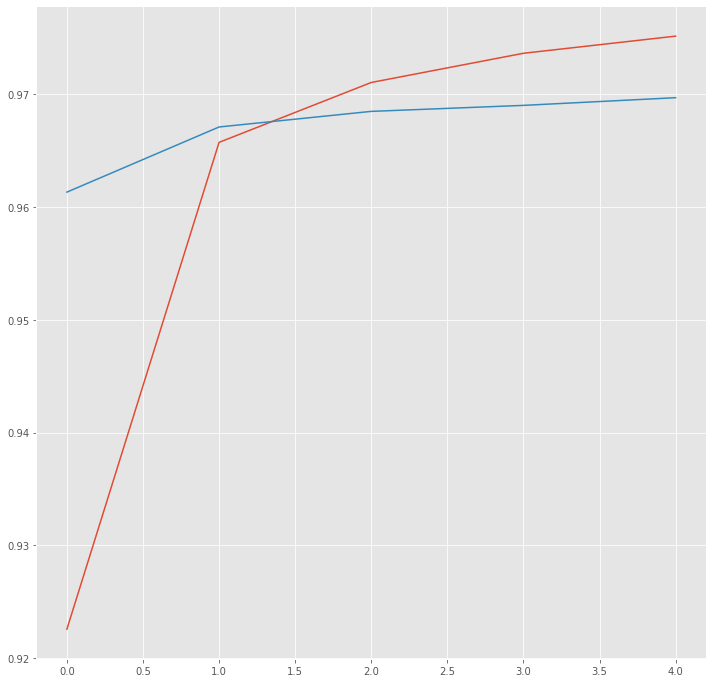

In [20]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist_1["acc"])
plt.plot(hist_1["val_acc"])
plt.show()

In [21]:
y_pred_1 = model_1.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])

In [22]:
i = 1925
p = np.argmax(y_pred_1[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2label[t], idx2label[pred]))

Word           ||True ||Pred
On             : O     O
Monday         : B-tim B-tim
,              : O     O
British        : B-org B-gpe
Foreign        : I-org O
Secretary      : B-per B-per
Jack           : I-per B-per
Straw          : I-per I-per
said           : O     O
his            : O     O
government     : O     O
has            : O     O
found          : O     O
no             : O     O
evidence       : O     O
the            : O     O
Bush           : B-org B-per
administration : O     O
requested      : O     O
permission     : O     O
to             : O     O
fly            : O     O
terror         : O     O
suspects       : O     O
through        : O     O
Britain        : B-geo B-geo
or             : O     O
its            : O     O
airspace       : O     O
.              : O     O


In [23]:
y_true_test = []
y_pred_test = []
for i in range(len(y_pred_1)):
    p = np.argmax(y_pred_1[i], axis=-1)
    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0:
            y_true_test.append(idx2label[t])
            y_pred_test.append(idx2label[pred])

In [24]:
report_1 = classification_report(y_pred=y_pred_test, y_true=y_true_test)
print(report_1)

C:\Users\linar\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       B-art       0.00      0.00      0.00        49
       B-eve       0.90      0.27      0.42        33
       B-geo       0.85      0.90      0.88      3735
       B-gpe       0.97      0.93      0.95      1596
       B-nat       0.34      0.43      0.38        23
       B-org       0.77      0.75      0.76      2071
       B-per       0.83      0.84      0.83      1694
       B-tim       0.92      0.87      0.89      2158
       I-art       0.00      0.00      0.00        42
       I-eve       0.45      0.15      0.23        33
       I-geo       0.77      0.83      0.80       707
       I-gpe       1.00      0.38      0.55        16
       I-nat       1.00      0.20      0.33         5
       I-org       0.81      0.79      0.80      1786
       I-per       0.87      0.88      0.87      1739
       I-tim       0.84      0.71      0.77       726
           O       0.99      0.99      0.99     89144

    accuracy              

# Model with Convolutional and MaxPooling layers for char embeddings

In [25]:
# input and embedding for words
word_in_2 = Input(shape=(max_len,), name='words_input')
emb_word_2 = Embedding(input_dim=len(word2Idx), output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in_2)

# input and embeddings for characters
char_in_2 = Input(shape=(max_len, max_len_char,), name='char_input')
embed_char_out_2 = TimeDistributed(Embedding(input_dim=len(char2idx), output_dim=10,
                           embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(char_in_2)

#the char embeddings are going through CNN and MaxPooling layer
dropout= Dropout(0.5)(embed_char_out_2)
conv1d_out= TimeDistributed(Conv1D(kernel_size=3, filters=10, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(0.5)(char)

# main LSTM
x_2 = concatenate([emb_word_2, char])
output = Bidirectional(LSTM(50, return_sequences=True, recurrent_dropout=0.6))(x_2)
output = TimeDistributed(Dense(len(label2Idx), activation='softmax'))(output)


model_2 = Model(inputs=[word_in_2, char_in_2], outputs=[output])



In [26]:
model_2.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=["acc"])
model_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, 75, 10)       0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, 75, 10, 10)   990         char_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 75, 10, 10)   0           char_embedding[0][0]             
__________________________________________________________________________________________________
time_distributed_3 (TimeDistrib (None, 75, 10, 10)   310         dropout_1[0][0]                  
____________________________________________________________________________________________

In [27]:
history_2 = model_2.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 95s 2ms/step - loss: 0.0791 - acc: 0.9283 - val_loss: 0.0367 - val_acc: 0.9617
Epoch 2/5
38846/38846 [==============================] - 92s 2ms/step - loss: 0.0302 - acc: 0.9690 - val_loss: 0.0316 - val_acc: 0.9670
Epoch 3/5
38846/38846 [==============================] - 90s 2ms/step - loss: 0.0237 - acc: 0.9749 - val_loss: 0.0309 - val_acc: 0.9674
Epoch 4/5
38846/38846 [==============================] - 93s 2ms/step - loss: 0.0206 - acc: 0.9774 - val_loss: 0.0300 - val_acc: 0.9682
Epoch 5/5
38846/38846 [==============================] - 95s 2ms/step - loss: 0.0182 - acc: 0.9797 - val_loss: 0.0309 - val_acc: 0.9681


In [28]:
y_pred_2 = model_2.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])

In [29]:
hist_2 = pd.DataFrame(history_2.history)
hist_2

,val_loss,val_acc,loss,acc
0,0.036748,0.961748,0.079129,0.928317
1,0.031585,0.967018,0.030221,0.968987
2,0.030896,0.967443,0.023706,0.974888
3,0.030015,0.968231,0.020570,0.977442
4,0.030942,0.968082,0.018205,0.979710


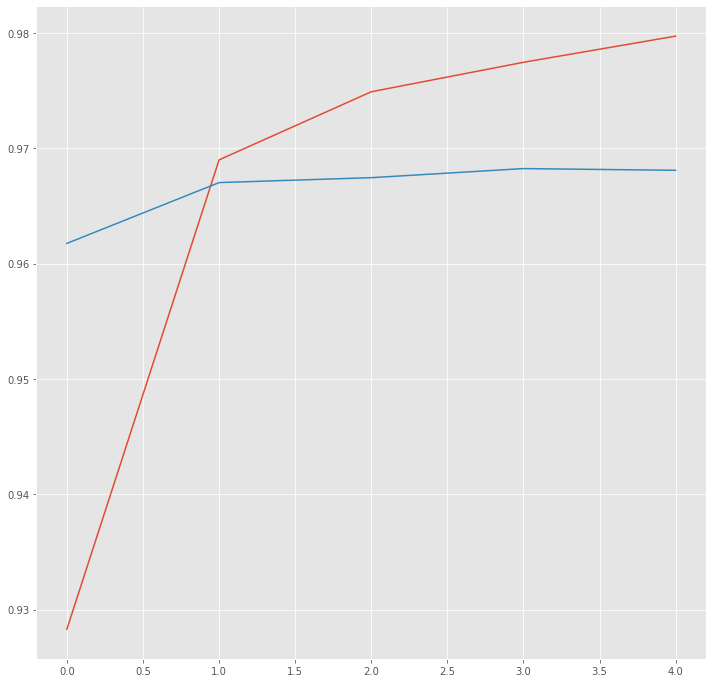

In [30]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist_2["acc"])
plt.plot(hist_2["val_acc"])
plt.show()

In [31]:
i = 1925
p = np.argmax(y_pred_2[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2label[t], idx2label[pred]))

Word           ||True ||Pred
On             : O     O
Monday         : B-tim B-tim
,              : O     O
British        : B-org B-gpe
Foreign        : I-org O
Secretary      : B-per B-per
Jack           : I-per B-per
Straw          : I-per I-per
said           : O     O
his            : O     O
government     : O     O
has            : O     O
found          : O     O
no             : O     O
evidence       : O     O
the            : O     O
Bush           : B-org B-per
administration : O     O
requested      : O     O
permission     : O     O
to             : O     O
fly            : O     O
terror         : O     O
suspects       : O     O
through        : O     O
Britain        : B-geo B-geo
or             : O     O
its            : O     O
airspace       : O     O
.              : O     O


In [32]:
y_true_test = []
y_pred_test = []
for i in range(len(y_pred_2)):
    p = np.argmax(y_pred_2[i], axis=-1)
    for w, t, pred in zip(X_word_te[i], y_te[i], p):
        if w != 0:
            y_true_test.append(idx2label[t])
            y_pred_test.append(idx2label[pred])

In [33]:
report_2 = classification_report(y_pred=y_pred_test, y_true=y_true_test)
print(report_2)

              precision    recall  f1-score   support

       B-art       0.43      0.06      0.11        49
       B-eve       0.43      0.36      0.39        33
       B-geo       0.87      0.87      0.87      3735
       B-gpe       0.96      0.94      0.95      1596
       B-nat       0.50      0.09      0.15        23
       B-org       0.78      0.74      0.76      2071
       B-per       0.84      0.83      0.84      1694
       B-tim       0.93      0.87      0.90      2158
       I-art       0.00      0.00      0.00        42
       I-eve       0.25      0.24      0.25        33
       I-geo       0.82      0.79      0.80       707
       I-gpe       1.00      0.38      0.55        16
       I-nat       1.00      0.20      0.33         5
       I-org       0.82      0.77      0.79      1786
       I-per       0.87      0.85      0.86      1739
       I-tim       0.84      0.69      0.76       726
           O       0.99      0.99      0.99     89144

    accuracy              

# Expand the model to BiLSTM-CNN-CRF

In [34]:
from keras.utils import to_categorical
y_CRF = [to_categorical(i, num_classes=len(label2Idx)) for i in y]
y_CRF[0]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [35]:
X_word_tr_CRF, X_word_te_CRF, y_tr_CRF, y_te_CRF = train_test_split(X_word, y_CRF, test_size=0.1, random_state=2018)
X_char_tr_CRF, X_char_te_CRF, _, _ = train_test_split(X_char, y_CRF, test_size=0.1, random_state=2018)

In [81]:
# input and embedding for words
word_in_3 = Input(shape=(max_len,), name='words_input')
emb_word_3 = Embedding(input_dim=len(word2Idx), output_dim=20,
                     input_length=max_len)(word_in_3)

# input and embeddings for characters
char_in_3 = Input(shape=(max_len, max_len_char,), name='char_input')
embed_char_out_3 = TimeDistributed(Embedding(input_dim=len(char2idx), output_dim=10,
                           embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name='char_embedding')(char_in_3)

#the char embeddings are going through CNN and MaxPooling layer
dropout= Dropout(0.5)(embed_char_out_3)
conv1d_out= TimeDistributed(Conv1D(kernel_size=3, filters=10, padding='same',activation='tanh', strides=1))(dropout)
maxpool_out=TimeDistributed(MaxPooling1D(max_len_char))(conv1d_out)
char = TimeDistributed(Flatten())(maxpool_out)
char = Dropout(0.5)(char)

# main LSTM
x_3 = concatenate([emb_word_3, char])
output_3 = Bidirectional(LSTM(50, return_sequences=True, recurrent_dropout=0.6))(x_3)
output_3 = TimeDistributed(Dense(50, activation=None))(output_3)


crf = CRF(len(label2Idx))
crf_output = crf(output_3)
model_3 = Model(inputs=[word_in_3, char_in_3], outputs=[crf_output])



In [82]:
model_3.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model_3.summary()

C:\Users\linar\anaconda3\lib\site-packages\keras_contrib\layers\crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
C:\Users\linar\anaconda3\lib\site-packages\keras_contrib\layers\crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, 75, 10)       0                                            
__________________________________________________________________________________________________
char_embedding (TimeDistributed (None, 75, 10, 10)   990         char_input[0][0]                 
__________________________________________________________________________________________________
dropout_39 (Dropout)            (None, 75, 10, 10)   0           char_embedding[0][0]             
__________________________________________________________________________________________________
time_distributed_78 (TimeDistri (None, 75, 10, 10)   310         dropout_39[0][0]                 
____________________________________________________________________________________________

In [84]:
history_3 = model_3.fit([X_word_tr_CRF,
                     np.array(X_char_tr_CRF).reshape((len(X_char_tr_CRF), max_len, max_len_char))],
                    np.array(y_tr_CRF),
                    batch_size=32, epochs=5, validation_split=0.1, verbose=1)

Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 151s 4ms/step - loss: -0.0710 - crf_viterbi_accuracy: 0.9921 - val_loss: -0.0760 - val_crf_viterbi_accuracy: 0.9909
Epoch 2/5
38846/38846 [==============================] - 168s 4ms/step - loss: -0.0881 - crf_viterbi_accuracy: 0.9923 - val_loss: -0.0926 - val_crf_viterbi_accuracy: 0.9911
Epoch 3/5
38846/38846 [==============================] - 171s 4ms/step - loss: -0.1049 - crf_viterbi_accuracy: 0.9927 - val_loss: -0.1089 - val_crf_viterbi_accuracy: 0.9911
Epoch 4/5
38846/38846 [==============================] - 171s 4ms/step - loss: -0.1217 - crf_viterbi_accuracy: 0.9929 - val_loss: -0.1252 - val_crf_viterbi_accuracy: 0.9909
Epoch 5/5
38846/38846 [==============================] - 170s 4ms/step - loss: -0.1383 - crf_viterbi_accuracy: 0.9931 - val_loss: -0.1413 - val_crf_viterbi_accuracy: 0.9908


In [85]:
y_pred_3 = model_3.predict([X_word_te_CRF,
                        np.array(X_char_te_CRF).reshape((len(X_char_te_CRF),
                                                     max_len, max_len_char))])

In [86]:
hist_3 = pd.DataFrame(history_3.history)
hist_3

,val_loss,val_crf_viterbi_accuracy,loss,crf_viterbi_accuracy
0,-0.076043,0.990856,-0.070994,0.992071
1,-0.092568,0.991089,-0.088067,0.992342
2,-0.108938,0.991077,-0.104916,0.992698
3,-0.125179,0.990950,-0.121657,0.992914
4,-0.141308,0.990799,-0.138337,0.993150


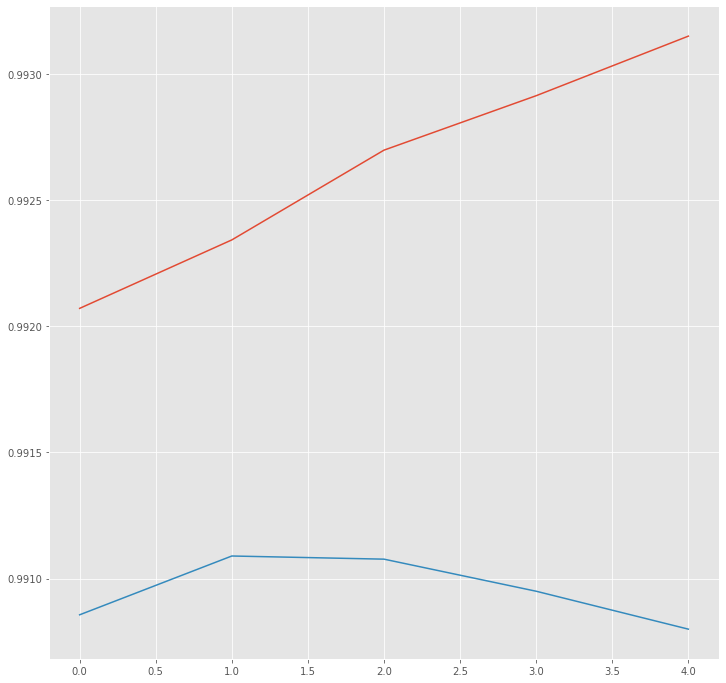

In [87]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist_3["crf_viterbi_accuracy"])
plt.plot(hist_3["val_crf_viterbi_accuracy"])
plt.show()

In [88]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2label[p_i].replace("PAD", "O"))
        out.append(out_i)
    return out
    
pred_labels = pred2label(y_pred_3)
test_labels = pred2label(y_te_CRF)


In [89]:
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 83.8%


In [90]:
print(classification_report(test_labels, pred_labels))

           precision    recall  f1-score   support

      geo       0.85      0.90      0.87      3735
      org       0.74      0.70      0.72      2071
      tim       0.86      0.86      0.86      2158
      gpe       0.97      0.93      0.95      1596
      per       0.82      0.76      0.79      1694
      art       0.50      0.02      0.04        49
      eve       0.45      0.27      0.34        33
      nat       0.41      0.30      0.35        23

micro avg       0.84      0.83      0.84     11359
macro avg       0.84      0.83      0.84     11359



In [91]:
i = 1925
p = np.argmax(y_pred_3[i], axis=-1)
true = np.argmax(y_te_CRF[i], -1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te_CRF[i], true, p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2label[t], idx2label[pred]))

Word           ||True ||Pred
On             : O     O
Monday         : B-tim B-tim
,              : O     O
British        : B-org B-org
Foreign        : I-org I-org
Secretary      : B-per B-per
Jack           : I-per I-per
Straw          : I-per I-per
said           : O     O
his            : O     O
government     : O     O
has            : O     O
found          : O     O
no             : O     O
evidence       : O     O
the            : O     O
Bush           : B-org B-per
administration : O     O
requested      : O     O
permission     : O     O
to             : O     O
fly            : O     O
terror         : O     O
suspects       : O     O
through        : O     O
Britain        : B-geo B-geo
or             : O     O
its            : O     O
airspace       : O     O
.              : O     O
